# 아이돌보미 관련 맘카페 게시글 감정분석

In [1]:
import pandas as pd
import pymongo
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='NanumBarunGothic') # 혹은 다른 설치한 Nanum 폰트 사용
import scipy
import scipy.stats as stats
from konlpy.tag import Okt
okt = Okt()
from mecab import MeCab
mecab = MeCab()
import pyLDAvis
import pyLDAvis.lda_model

# 데이터 로드 

## 감정 사전 로드

In [2]:
sentiword = pd.read_json('../../dataset/SentiWord_info.json')
sentiword

,word,word_root,polarity
0,(-;,(,1
1,(;_;),(;_;),-1
2,(^^),(^^),1
3,(^-^),(^-^),1
4,(^^*,(,1
...,...,...,...
14849,반신반의하다,반신반의,0
14850,신비롭다,신비,1
14851,아리송하다,아리송,-1
14852,알쏭하다,알쏭하,-1


## 게시글 데이터 로드

In [3]:
baby_care_contents = pd.read_json('../../dataset/baby_care_naver_cafe/baby_care_contents.json')
baby_care_contents.drop('_id',axis=1,inplace=True)
# baby_care_contents

# 데이터 전처리

## 중복값 제거

In [4]:
baby_care_contents.drop_duplicates(keep='first',inplace=True)
baby_care_contents.reset_index(inplace=True)
baby_care_contents.drop('index',axis=1,inplace=True)
baby_care_contents

,title,date,contents,like
0,아이돌보미(시터) 선생님 스타일이 너무 안맞으면 어떻게 하시나요?,2024-08-07 11:10:00,나이가 좀 많으세요\n저희 친정 시댁 어른들보다도 6살 더 많으심....\n그래서 ...,0
1,남편이랑 싸운 다음날 육아,2024-08-07 09:41:00,어제 남편하고 싸우고 나니까\n아침에 애기는 너무 귀여운데 육아하기 싫고\n잠깐 어...,1
2,맘님이 애가 어리고 복직을 꼭 해야하는 상황,2024-08-06 13:06:00,저는 어렸을때부터 애기를 너무 좋아했고 처녀때 조카들도 다 키웠다 할만큼 맨날 놀러...,0
3,필리핀 가사도우미? 신청하신 분 있으세요?,2024-08-06 10:30:00,서울시에서 신청받고있는 필리핀 가사도우미? 가사관리사?\n정확하게말하면 도우미 관리...,0
4,아이돌보미 서비스 신청 결제 관련해서 여쭤봅니다,2024-08-04 12:29:00,"안녕하세요.\n여행 다녀와서 애기, 저, 친정엄마 세명 다 코로나 확진\n판정 받고...",0
...,...,...,...,...
2042,정부지원 아이돌보미 서비스...황당해요,2017-10-25 17:39:00,"★ 잠깐! 게시글 작성 전, 필독 공지! ★\n- 카페규정 : http://cafe...",2
2043,아이돌보미 시간제보육ㅠ,2017-10-25 02:48:00,1월에 회사에 복직해요~ 계속 일할건 아니고\n두달정도만 나가면 될것같아요.\n...,0
2044,정부지원 아이돌보미 서비스...황당해요,2017-10-25 17:39:00,"★ 잠깐! 게시글 작성 전, 필독 공지! ★\n- 카페규정 : http://cafe...",0
2045,아이돌봄서비스 이용하시는분들께 질문드려요~,2017-11-29 23:43:00,곧 출근 앞두고 있는데요..\n아이돌봄서비스 처음 이용해봐요~~\n6세 3세 형제예...,0


## 긍,부정 단어 사전에서 필요없는 단어 제거

In [5]:
sentiword = sentiword.loc[~sentiword['word'].isin(['함께','받다'])]

## 필요없는 데이터 삭제

In [6]:
baby_care_contents = baby_care_contents.loc[~baby_care_contents['contents'].str.contains('가족센터')]
baby_care_contents = baby_care_contents.loc[baby_care_contents['contents'].str.contains('아이돌보미')|baby_care_contents['contents'].str.contains('아이돌봄서비스')|baby_care_contents['contents'].str.contains('아이 돌보미')|baby_care_contents['contents'].str.contains('아이 돌봄서비스')|baby_care_contents['contents'].str.contains('아이돌봄 서비스')|baby_care_contents['contents'].str.contains('아이 돌봄 서비스')|baby_care_contents['title'].str.contains('아이돌보미')|baby_care_contents['title'].str.contains('아이돌봄서비스')|baby_care_contents['title'].str.contains('아이 돌보미')|baby_care_contents['title'].str.contains('아이 돌봄서비스')|baby_care_contents['title'].str.contains('아이돌봄 서비스')|baby_care_contents['title'].str.contains('아이 돌봄 서비스')]

## 데이터 형태 변환

In [7]:
baby_care_contents['like'] =baby_care_contents['like'].astype(int)
baby_care_contents['date'] = baby_care_contents['date'].dt.date

## 줄바꿈 제거

In [8]:
baby_care_contents['contents'] = baby_care_contents['contents'].str.replace('\n',' ')
baby_care_contents['contents'] = baby_care_contents['contents'].str.replace('★ 잠깐! 게시글 작성 전, 필독 공지! ★ - 카페규정 : http://cafe.naver.com/imsanbu/28123090  - 게시판별 운영 정책 : http://cafe.naver.com/imsanbu/35756864',' ')

## 형태소 분리

In [9]:
from konlpy.tag import Okt
okt = Okt()
def Tokenizer(raw):
    word_list = []
    for word, tag in okt.pos(raw,norm=True,stem=True):
        word_list.append(word)
    return " ".join(word_list)

In [10]:
baby_care_contents['contents_clean'] = baby_care_contents['contents'].apply(Tokenizer)
baby_care_contents

,title,date,contents,like,contents_clean
0,아이돌보미(시터) 선생님 스타일이 너무 안맞으면 어떻게 하시나요?,2024-08-07,나이가 좀 많으세요 저희 친정 시댁 어른들보다도 6살 더 많으심.... 그래서 그런...,0,나이 가 좀 많다 저희 친정 시댁 어른 들 보다도 6 살 더 많다 심 .... 그래...
3,필리핀 가사도우미? 신청하신 분 있으세요?,2024-08-06,서울시에서 신청받고있는 필리핀 가사도우미? 가사관리사? 정확하게말하면 도우미 관리사...,0,서울시 에서 신청 받다 필리핀 가사 도우미 ? 가사 관리사 ? 정확하다 도우미 관리...
4,아이돌보미 서비스 신청 결제 관련해서 여쭤봅니다,2024-08-04,"안녕하세요. 여행 다녀와서 애기, 저, 친정엄마 세명 다 코로나 확진 판정 받고 집...",0,"안녕하다 . 여행 다녀오다 애기 , 저 , 친정엄마 세명 다 코로나 확진 판정 받다..."
5,아이돌보미 문의,2024-08-04,7살아들~~내년에 초등학교입학입니다. 입학하면 수업이 일찍 끝나서 그 이후 학원 1...,0,7 살 아들 ~~ 내년 에 초등학교 입학 이다 . 입학 하다 수업 이 일찍 끝나다 ...
6,어린이집과 정부지원아이돌보미는 같이 이용 못하는건가요?,2024-08-02,아예 처음 이용해보려고 알아보고 있어서요! 두개 중복은 안되는건가요? 어린이집을 오...,0,아예 처음 이용 해보다 알아보다 있다 ! 두 개 중복 은 안되다 가요 ? 어린이집 ...
...,...,...,...,...,...
2042,정부지원 아이돌보미 서비스...황당해요,2017-10-25,지금 맞벌이로 일을 하고는있는데 지인소개로 간곳이고 아기가 아직어리고 어린...,2,지금 맞벌이 로 일 을 하다 지인 소개 로 간곳 이고 아기 가 아직 어리다 어린이집...
2043,아이돌보미 시간제보육ㅠ,2017-10-25,1월에 회사에 복직해요~ 계속 일할건 아니고 두달정도만 나가면 될것같아요. 1월...,0,1월 에 회사 에 복직 하다 ~ 계속 일 하다 아니다 두 달 정도 만 나가다 되다 ...
2044,정부지원 아이돌보미 서비스...황당해요,2017-10-25,지금 맞벌이로 일을 하고는있는데 지인소개로 간곳이고 아기가 아직어리고 어린...,0,지금 맞벌이 로 일 을 하다 지인 소개 로 간곳 이고 아기 가 아직 어리다 어린이집...
2045,아이돌봄서비스 이용하시는분들께 질문드려요~,2017-11-29,곧 출근 앞두고 있는데요.. 아이돌봄서비스 처음 이용해봐요~~ 6세 3세 형제예요....,0,곧 출근 앞두다 있다 .. 아이돌 봄 서비스 처음 이용 해보다 ~~ 6 세 3 세 ...


# 긍, 부정 분류

In [11]:
def get_morphs(raw):
    pos = list(sentiword.loc[sentiword['polarity']==1]['word'])
    neg = list(sentiword.loc[sentiword['polarity']==-1]['word'])
    raw_list = raw.split(' ')
    pos_list = []
    neg_list = []
    for morph in raw_list:
        if morph in pos:
            pos_list.append(morph)
        elif morph in neg:
            neg_list.append(morph)
    if len(pos_list) > len(neg_list):
        return pos_list
    elif len(pos_list) < len(neg_list):
        return neg_list
    else:
        return []

def get_score(raw):
    pos = list(sentiword.loc[sentiword['polarity']==1]['word'])
    neg = list(sentiword.loc[sentiword['polarity']==-1]['word'])
    raw_list = raw.split(' ')
    pos_list = []
    neg_list = []
    for morph in raw_list:
        if morph in pos:
            pos_list.append(morph)
        elif morph in neg:
            neg_list.append(morph)
    if len(pos_list) > len(neg_list):
        return len(pos_list)
    elif len(pos_list) < len(neg_list):
        return -len(neg_list)
    else:
        return 0

    return len(raw)

def get_label(raw):
    if raw > 0 :
        label = "긍정"
    elif raw < 0 :
        label = "부정"
    else:
        label = "중립"
    
    return label

In [12]:
baby_care_contents['words_list'] = baby_care_contents['contents_clean'].apply(get_morphs)
baby_care_contents['score'] = baby_care_contents['contents_clean'].apply(get_score)
baby_care_contents['label'] = baby_care_contents['score'].apply(get_label)

In [13]:
baby_care_contents['label'] = baby_care_contents['score'].apply(get_label)

In [14]:
baby_care_contents

,title,date,contents,like,contents_clean,words_list,score,label
0,아이돌보미(시터) 선생님 스타일이 너무 안맞으면 어떻게 하시나요?,2024-08-07,나이가 좀 많으세요 저희 친정 시댁 어른들보다도 6살 더 많으심.... 그래서 그런...,0,나이 가 좀 많다 저희 친정 시댁 어른 들 보다도 6 살 더 많다 심 .... 그래...,[],0,중립
3,필리핀 가사도우미? 신청하신 분 있으세요?,2024-08-06,서울시에서 신청받고있는 필리핀 가사도우미? 가사관리사? 정확하게말하면 도우미 관리사...,0,서울시 에서 신청 받다 필리핀 가사 도우미 ? 가사 관리사 ? 정확하다 도우미 관리...,[],0,중립
4,아이돌보미 서비스 신청 결제 관련해서 여쭤봅니다,2024-08-04,"안녕하세요. 여행 다녀와서 애기, 저, 친정엄마 세명 다 코로나 확진 판정 받고 집...",0,"안녕하다 . 여행 다녀오다 애기 , 저 , 친정엄마 세명 다 코로나 확진 판정 받다...",[없다],-1,부정
5,아이돌보미 문의,2024-08-04,7살아들~~내년에 초등학교입학입니다. 입학하면 수업이 일찍 끝나서 그 이후 학원 1...,0,7 살 아들 ~~ 내년 에 초등학교 입학 이다 . 입학 하다 수업 이 일찍 끝나다 ...,[빠르다],1,긍정
6,어린이집과 정부지원아이돌보미는 같이 이용 못하는건가요?,2024-08-02,아예 처음 이용해보려고 알아보고 있어서요! 두개 중복은 안되는건가요? 어린이집을 오...,0,아예 처음 이용 해보다 알아보다 있다 ! 두 개 중복 은 안되다 가요 ? 어린이집 ...,[],0,중립
...,...,...,...,...,...,...,...,...
2042,정부지원 아이돌보미 서비스...황당해요,2017-10-25,지금 맞벌이로 일을 하고는있는데 지인소개로 간곳이고 아기가 아직어리고 어린...,2,지금 맞벌이 로 일 을 하다 지인 소개 로 간곳 이고 아기 가 아직 어리다 어린이집...,"[없다, 없다, 없다, 없다, 그만두다]",-5,부정
2043,아이돌보미 시간제보육ㅠ,2017-10-25,1월에 회사에 복직해요~ 계속 일할건 아니고 두달정도만 나가면 될것같아요. 1월...,0,1월 에 회사 에 복직 하다 ~ 계속 일 하다 아니다 두 달 정도 만 나가다 되다 ...,"[친구, 도와주다, 괜찮다, 잘, 친구]",5,긍정
2044,정부지원 아이돌보미 서비스...황당해요,2017-10-25,지금 맞벌이로 일을 하고는있는데 지인소개로 간곳이고 아기가 아직어리고 어린...,0,지금 맞벌이 로 일 을 하다 지인 소개 로 간곳 이고 아기 가 아직 어리다 어린이집...,"[없다, 없다, 없다, 없다, 그만두다]",-5,부정
2045,아이돌봄서비스 이용하시는분들께 질문드려요~,2017-11-29,곧 출근 앞두고 있는데요.. 아이돌봄서비스 처음 이용해봐요~~ 6세 3세 형제예요....,0,곧 출근 앞두다 있다 .. 아이돌 봄 서비스 처음 이용 해보다 ~~ 6 세 3 세 ...,"[없다, 이상하다]",-2,부정


# 긍, 부정, 중립 게시글 비교

In [16]:
baby_care_contents['label'].value_counts()

label
부정    708
중립    555
긍정    450
Name: count, dtype: int64

# 연도별 긍, 부정, 중립 게시글 갯수
- 2019년 4월 금천구 아이돌보미 폭행 사건 당시 관련 게시글 수가 증가함
- https://www.electimes.com/news/articleView.html?idxno=176583 

In [17]:
baby_care_contents['date'] = pd.to_datetime(baby_care_contents['date'])
baby_care_contents['year_month'] = baby_care_contents['date'].dt.strftime('%Y')
grouped = baby_care_contents.groupby(['year_month','label'])['title'].count().reset_index()


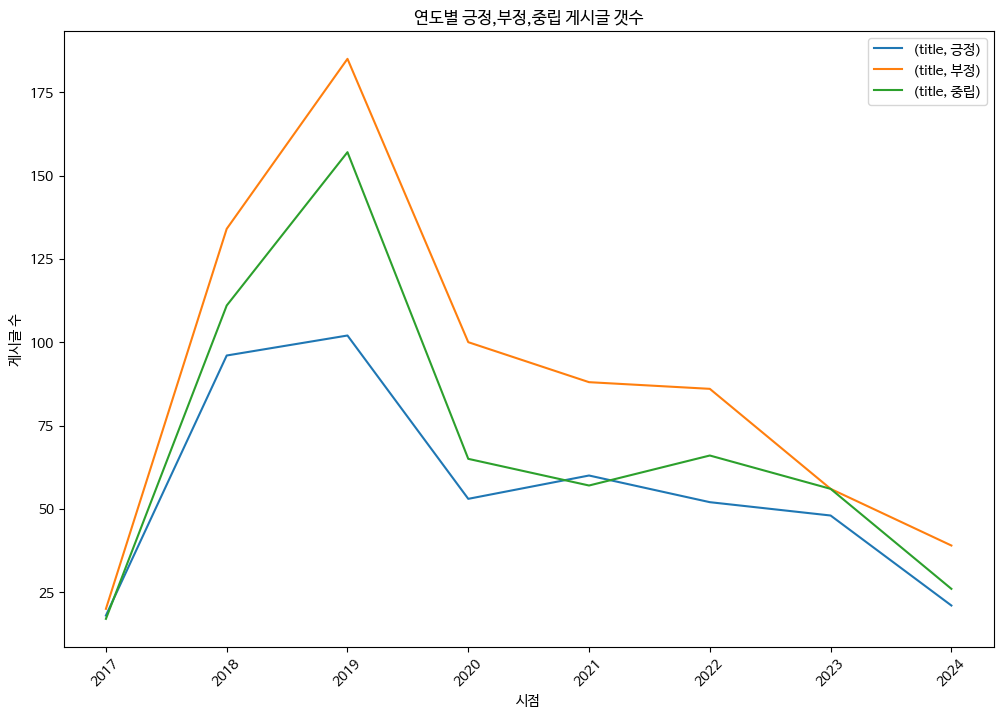

In [18]:
df_pivot = pd.pivot_table(grouped,index='year_month',columns = ['label'],values=['title'])
df_pivot.plot(kind='line',figsize=(12,8))
plt.xlabel('시점')
plt.ylabel('게시글 수')
plt.title('연도별 긍정,부정,중립 게시글 갯수')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()


# 긍정 게시글 토픽 분류

In [19]:
positive_contents = baby_care_contents.loc[(baby_care_contents['label']=='긍정')]

In [69]:
stopwords = ['보미','아이','아기','신분','가요','대요','도우미','계속','정도','이모']
def Tokenizer_noun(raw, pos=["Noun"], stopword=stopwords):
    word_list = []
    for word, tag in okt.pos(raw,norm=True,stem=True):
        if len(word) > 1 and tag in pos and word not in stopword:
            if mecab.pos(word)[0][1] in ["NNG"]:
                word_list.append(word)
    return " ".join(word_list)

In [70]:
def noun_set(raw):
    noun_list = list(set(raw.split(' ')))
    return " ".join(noun_list)

In [94]:
positive_contents['noun_list'] = positive_contents['contents'].apply(Tokenizer_noun)

In [95]:
positive_contents['noun_set'] = positive_contents['noun_list'].apply(noun_set)

In [152]:
positive_contents = positive_contents.query("noun_list !=''")
positive_contents = positive_contents.reset_index()
positive_contents = positive_contents.loc[:,'title':]

In [145]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfVectorizer_topic = TfidfVectorizer(use_idf=True,max_df=0.8,min_df=0.02,ngram_range=(1,2))
features = tfidfVectorizer_topic.fit_transform(positive_contents['noun_list'])
features.toarray()[:2]
dictionary_list = tfidfVectorizer_topic.get_feature_names_out()


In [146]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=3, random_state=36) #인스턴스화 #n_components 토픽의 갯수
lda_model.fit(features)
import pandas as pd
pd.set_option('display.max_colwidth', None)
## 상위 단어 추출 
## 0 확률 1은 dictionary
topics_list = list()
for topic in lda_model.components_:
    df_datas = [topic, dictionary_list]
    df_topics = pd.DataFrame(data=df_datas)
    df_topics= df_topics.T
    df_topics = df_topics.sort_values(0, ascending=False)
    # print(df_topics[:3])
    topics_text = ' '.join(df_topics[1].values[:20])# 시리즈 형식으로 출력 get values from series / index 
    topics_list.append(topics_text)
topics_list_add = [['Topic1', 'Topic2','Topic3'],topics_list]
df_topics_keywords = pd.DataFrame(topics_list_add)
df_topics_keywords=df_topics_keywords.T
df_topics_keywords

,0,1
0,Topic1,선생님 신청 시간 하원 이용 엄마 생각 복직 혼자 소득 면접 남편 대기 연락 정부 예정 출근 사람 이번 주말
1,Topic2,서비스 어린이집 이용 신청 지원 정부 시간 육아 산후 생각 업체 서비스 이용 고민 도움 엄마 경우 가정 시간제 선생님 보육
2,Topic3,아침 선물 월급 선생님 오전 정리 정부 오후 청소 지원 정부 지원 목욕 얼마 처음 저녁 젖병 막내 추천 빨래 건가


In [147]:
list_topics = []
for i in range(len(lda_model.components_)):
    df_datas = [lda_model.components_[i], dictionary_list]
    df_topics = pd.DataFrame(data=df_datas).T
    df_topics = df_topics.dropna()
    df_topics = df_topics.sort_values(0, ascending=False).reset_index()
    df_topics.rename(columns = {1 : i+1}, inplace = True)
    df_topics.rename(columns = {0 : 'score'}, inplace = True)
    list_topics.append(df_topics.loc[:4,['score',i+1]])
df_topic = pd.concat(list_topics,axis=1)
df_topic

,score,1,score,2,score,3
0,13.905415,선생님,21.13865,서비스,5.601949,아침
1,13.672138,신청,19.030526,어린이집,5.264546,선물
2,12.486992,시간,14.67417,이용,5.134623,월급
3,10.615601,하원,13.751215,신청,4.918732,선생님
4,10.190082,이용,12.11119,지원,4.813821,오전


In [148]:
import pyLDAvis
import pyLDAvis.lda_model
vis = pyLDAvis.lda_model.prepare(lda_model,features,tfidfVectorizer_topic)
vis
pyLDAvis.enable_notebook()
components_display = pyLDAvis.display(vis)
components_display

In [149]:
topics_list = list()
for topic in lda_model.components_:
    df_datas = [topic, dictionary_list]
    df_topics = pd.DataFrame(data=df_datas)
    df_topics= df_topics.T
    df_topics = df_topics.sort_values(0, ascending=False)

In [150]:
topics_output = lda_model.transform(features)
df_topics_score = pd.DataFrame(topics_output)
df_topics_score['dominant_topic_number']=np.argmax(topics_output, axis=1)
df_topics_score['dominant_topic_number'].value_counts()

dominant_topic_number
1    202
0    195
2     53
Name: count, dtype: int64

In [151]:
positive_contents.loc[:,'content_topic'] = df_topics_score['dominant_topic_number']
positive_contents

title       date  \
0                            아이돌보미 문의 2024-08-04   
1                     아이돌보미 하시는분 질문이요 2024-08-01   
2                  아이돌봄, 등하원돌보미 구해보신분 2024-06-25   
3       등원하원도우미, 아이돌보미서비스 아시거나 이용해보신분 2024-06-24   
4                  업체통해서 시터쓰시는분 계신가요? 2024-06-22   
..                                ...        ...   
445    첫째, 둘째 다 가정보육중 시간제아이돌보미 써보신분?? 2017-11-17   
446  첫째아이 돌보미 하게 되면 엄마들 무얼 제일 하고싶으세요? 2017-11-03   
447                             아이돌보미 2017-10-31   
448             첫단추 산후조리원 성북점 후기예요~^^ 2017-10-29   
449                      아이돌보미 시간제보육ㅠ 2017-10-25   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

# 부정 게시글 토픽 분류

In [80]:
negative_contents = baby_care_contents.loc[(baby_care_contents['label']=='부정')]

In [153]:
negative_contents['noun_list'] = negative_contents['contents'].apply(Tokenizer_noun)

In [154]:
negative_contents['noun_set'] = negative_contents['noun_list'].apply(noun_set)

In [83]:
negative_contents = negative_contents.query("noun_list !=''")
negative_contents = negative_contents.reset_index()
negative_contents = negative_contents.loc[:,'title':]
# negative_contents

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfVectorizer_topic = TfidfVectorizer(use_idf=True,max_df=0.8,min_df=0.05,ngram_range=(1,2))
features = tfidfVectorizer_topic.fit_transform(negative_contents['noun_list'])
features.toarray()[:2]
dictionary_list = tfidfVectorizer_topic.get_feature_names_out()


In [124]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=3, random_state=36) #인스턴스화 #n_components 토픽의 갯수
lda_model.fit(features)
import pandas as pd
pd.set_option('display.max_colwidth', None)
## 상위 단어 추출 
## 0 확률 1은 dictionary
topics_list = list()
for topic in lda_model.components_:
    df_datas = [topic, dictionary_list]
    df_topics = pd.DataFrame(data=df_datas)
    df_topics= df_topics.T
    df_topics = df_topics.sort_values(0, ascending=False)
    # print(df_topics[:3])
    topics_text = ' '.join(df_topics[1].values[:20])# 시리즈 형식으로 출력 get values from series / index 
    topics_list.append(topics_text)
topics_list_add = [['Topic1', 'Topic2','Topic3'],topics_list]
df_topics_keywords = pd.DataFrame(topics_list_add)
df_topics_keywords=df_topics_keywords.T
df_topics_keywords

,0,1
0,Topic1,선생님 신청 시간 하원 이용 엄마 생각 복직 혼자 소득 면접 남편 대기 연락 정부 예정 출근 사람 이번 주말
1,Topic2,서비스 어린이집 이용 신청 지원 정부 시간 육아 산후 생각 업체 서비스 이용 고민 도움 엄마 경우 가정 시간제 선생님 보육
2,Topic3,아침 선물 월급 선생님 오전 정리 정부 오후 청소 지원 정부 지원 목욕 얼마 처음 저녁 젖병 막내 추천 빨래 건가


In [125]:
list_topics = []
for i in range(len(lda_model.components_)):
    df_datas = [lda_model.components_[i], dictionary_list]
    df_topics = pd.DataFrame(data=df_datas).T
    df_topics = df_topics.dropna()
    df_topics = df_topics.sort_values(0, ascending=False).reset_index()
    df_topics.rename(columns = {1 : i+1}, inplace = True)
    df_topics.rename(columns = {0 : 'score'}, inplace = True)
    list_topics.append(df_topics.loc[:4,['score',i+1]])
df_topic = pd.concat(list_topics,axis=1)
df_topic

,score,1,score,2,score,3
0,13.905415,선생님,21.13865,서비스,5.601949,아침
1,13.672138,신청,19.030526,어린이집,5.264546,선물
2,12.486992,시간,14.67417,이용,5.134623,월급
3,10.615601,하원,13.751215,신청,4.918732,선생님
4,10.190082,이용,12.11119,지원,4.813821,오전


In [126]:
import pyLDAvis
import pyLDAvis.lda_model
vis = pyLDAvis.lda_model.prepare(lda_model,features,tfidfVectorizer_topic)
vis
pyLDAvis.enable_notebook()
components_display = pyLDAvis.display(vis)
components_display

In [127]:
topics_list = list()
for topic in lda_model.components_:
    df_datas = [topic, dictionary_list]
    df_topics = pd.DataFrame(data=df_datas)
    df_topics= df_topics.T
    df_topics = df_topics.sort_values(0, ascending=False)

In [128]:
topics_output = lda_model.transform(features)
df_topics_score = pd.DataFrame(topics_output)
df_topics_score['dominant_topic_number']=np.argmax(topics_output, axis=1)
df_topics_score['dominant_topic_number'].value_counts()

dominant_topic_number
1    202
0    195
2     53
Name: count, dtype: int64

In [143]:
negative_contents.loc[:,'content_topic'] = df_topics_score['dominant_topic_number']
negative_contents

,title,date,contents,like,contents_clean,words_list,score,label,year_month,noun_list,noun_set,content_topic
0,아이돌보미 서비스 신청 결제 관련해서 여쭤봅니다,2024-08-04,"안녕하세요. 여행 다녀와서 애기, 저, 친정엄마 세명 다 코로나 확진 판정 받고 집에서 칩거 육아 7일차 입니다ㅠㅠ 한창 아플때 아이돌보미 서비스는 질병케어도 가능하다고 해서 신청했고, 이제 승인 완료 되었네요. 제가 육휴중이라 시간제로 해서 신청했고, 시간제-가/나/다 별로 이제 자기 부담금이 다른걸로 알고 있어요. 국민행복카드를 통해서 결제한다고 알고 있는데 아이돌보미 서비스 신청 후 돌보미 선생님 오시면 국민행복카드로 시간제 유형별 해당 금액만 결제되는 시스템인지 궁금합니다. 주변에서 해본 사람도 없고 해서 해보신 분들 조언 부탁드립니다🙌🏻",0,"안녕하다 . 여행 다녀오다 애기 , 저 , 친정엄마 세명 다 코로나 확진 판정 받다 집 에서 칩거 육아 7일 차 이다 ㅠㅠ 한창 아프다 때 아이돌 보미 서비스 는 질병 케어 도 가능하다 하다 신청 하다 , 이제 승인 완료 되어다 . 제 가 육 휴 중이 라 시간제 로 하다 신청 하다 , 시간제 - 가다 / 나 / 다 별로 이제 자기 부담 금 이 다른 것 으로 알 고 있다 . 국민 행복 카드 를 통해 서 결제 하다 알 고 있다 아이돌 보미 서비스 신청 후 돌 보미 선생님 오시 면 국민 행복 카드 로 시간제 유형 별 해당 금액 만 결제 되다 시스템 인지 궁금하다 . 주변 에서 해보다 사람 도 없다 하다 해보다 분들 조언 부탁드리다 🙌🏻",[없다],-1,부정,2024,여행 애기 친정엄마 확진 판정 칩거 육아 서비스 질병 케어 신청 승인 완료 중이 시간제 신청 시간제 부담 국민 행복 카드 결제 서비스 신청 선생님 국민 행복 카드 시간제 유형 해당 금액 결제 시스템 주변 사람 조언,확진 애기 선생님 육아 신청 칩거 완료 카드 해당 서비스 여행 금액 사람 시스템 주변 시간제 유형 결제 질병 케어 판정 조언 승인 부담 행복 중이 친정엄마 국민,2.0
1,공무원 육아시간 쓰겠댔다가 대놓고 반대+불만이 너무 심해서 앉은 자리에서 펑펑 울었어요.,2024-08-02,"7.22. 전보발령받고 열흘동안 남편이 오전지각 두시간 오후육아시간 두시간 또 애들 방학이라 연가 많이 남은 남편이 거의 매일같이 연가 써서 애들 등하원 시키고 보고 하다가 이제 나도 8월9일부터 육아시간써서 오전1시간반 초과 근무수당 포기하고 두시간 늦게 출근하겠댔더니 반응. 계장1. -나 때는 그런 거 없어서 나는 못 썼다. 그래서 지금 쓰는 사람 싫다. 우리 소는 인원이 적은 곳이라 육아시간 쓰는 사람이 오면 안 된다. (출근 2~3일 째 점심식사 때) -(우리 부는 여직원이 많은 기관이라 앞으로 이런 사례가 점점 많아질 것이다.) 그러면 그런 직원은 본부 차원에서 우리 기관으로 발령을 보내면 안 된다. -(육아시간을 쓰지 못하면 저는 휴직을 해야하는데 휴직도 안 된다고 하지 않으셨냐) 그렇게 말한 적 없다. 휴직하면 우리는 본청에 파견인력 지원하면 된다. (저는 이 말을 육아시간을 쓸 바에는 휴직하라는 말로 이해함) -다른 직원도 몸이 아픈데 걔는 조퇴를 쓴다. -일하고 있는데 네가 육아시간을 쓰면 나머지 직원들 사기가 떨어진다. -네가 열흘 간 오전에 덜 바쁘다고 느껴서 지금 이런 요구를 한다. -네 전임자도 육아시간 썼었는데 문제가 많아서 못쓰게 했고 본청에서도 못쓰게 하고 있다. 못 쓰게 하는 게 추세다. 계장2. -앞으로 계속 쓰겠다는 거냐? 한시적으로 쓰는 게 아닌 계속 쓴다는 거는 나머지 직원들 사기가 떨어진다. -한 달, 한 달 반 정도 써 보고 일이 잘 돌아가는지 보고 결정하면 좋겠다. 과장 -매일같이 쓴다는 거는 문제가 있다. -애들을 회사에 데려와라. 내가 봐주겠다. -그렇게 육아시간을 쓰면 좀 상황이 나아지나? 둥글게 들어앉은 자리에서 저렇게 집단린치 당하고 그자리에서 펑펑 울었습니다. 과장 말처럼 매일 쓰는 건 아니고요 보안근무인날 주말근무인 날은 안 씁니다. 그리고 전국 사무소에서 업무량이 제일 적다고 할 정도로 한산한 곳입니다. 다른 사람이 연가 등 쓰거나 오전에 일이 많을 게 예상될 때도 안 쓰고 대신 남편이 오전 지각 달고 등원시키겠다 했습니다. 아이돌보미 대기만 1년이고, 사설 도우미 구할랬더니 인당 13천원 해서 시간당 26천원 달랍니다. 이마저도 제 근무요일이 매번 들쭉날쭉 고정적이지가 않아서 하겠다는 사람도 없어요. 다행히 소장 혼자 이해해주고 허가해줘서 쓰는 걸로 되긴 됐다만 애들 키우면서 일하는 거 굴욕적입니다. 애 낳은 죄.",7,"7.22 . 전보발령 받다 열흘 동안 남편 이 오전 지각 두 시간 오후 육아 시간 두 시간 또 애 들 방학 이라 연가 많이 남다 남편 이 거의 매일 같이 연가 써다 애 들 등 하원 시키다 보고 하다 이제 나다 8월 9일 부터 육 아시 간 써다 오전 1시간 반 초과 근무 수당 포기 하고 두 시간 늦다 출근 하다 대다 반응 . 계장 1 . - 나 때 는 그렇다 거 없다 나 는 못 써다 . 그래서 지금 쓰다 사람 싫다 . 우리 소 는 인원 이 적다 곳 이라 육아 시간 쓰다 사람 이 오다 안 되다 . ( 출근 2~3일 째다 점심식사 때 ) -( 우리 불다 여직원 이 많다 기관 이라 앞 으로 이렇다 사례 가 점점 많아지다 것 이다 .) 그러면 그렇다 직원 은 본부 차원 에서 우리 기관 으로 발령 을 보내다 안 되다 . -( 육 아시 간 을 쓰다 못 하다 저 는 휴직 을 하다 휴직 도 안 되다 하다 않다 ) 그렇게 말 한 적 없다 . 휴직 하다 우리 는 본 청 에 파견 인력 지원 하다 되다 . ( 저 는 이 말 을 육 아시 간 을 쓸다 바 에는 휴직 하 라는 말로 이해 함 ) - 다른 직원 도 몸 이 아프다 걔 는 조퇴 를 쓴다 . - 일 하고 있다 네 가 육 아시 간 을 쓰다 나머지 직원 들 사기 가 떨어지다 . - 네 가 열흘 간 오전 에 덜 바쁘다 느끼다 지금 이렇다 요구 를 하다 . - 네 전 임자도 육아 시간 써다 문제 가 많다 못 쓰다 하다 본 청 에서도 못 쓰다 하다 있다 . 못 쓰다 하다 게 추세 다 . 계장 2 . - 앞 으로 계속 쓰다 거 냐 ? 한시 적 으로 쓰다 게 아니다 계속 쓴다 거 는 나머지 직원 들 사기 가 떨어지다 . - 하다 달 , 하다 달 반 정도 써다 보고 일이 자다 돌아가다 보고 결정 하다 좋다 . 과장 - 매일 같이 쓴다 거 는 문제 가 있다 . - 애 들 을 회사 에 데려오다 . 내 가 보다 . - 그렇게 육 아시 간 을 쓰다 좀 상황 이 나아지다 ? 둥글다 들다 앉다 자리 에서 저렇게 집단 린치 당하다 그 자리 에서 펑펑 울다 . 과장 말 처럼 매일 쓰다 건 아니다 보안 근무 인 날 주말 근무 인 날 은 안 쓰다 . 그리고 전국 사무소 에서 업 무량 이 제일 적다 하다 정도 로 한산하다 곳 이다 . 다른 사람 이 연가 등 쓰다 오전 에 일이 많다 게 예상 되다 때 도 안 쓰다 대신 남편 이 오전 지각 달 고 등원 시키다 하다 . 아이돌 보미 대기 만 1년 이고 , 사설 도우미 구할랬더 니 이다 13천원 하다 시간 당 26천원 달다 . 이 마저도 제 근무 요일 이 매번 들쭉날쭉 고정 적 이지 가 않다 하다 사람 도 없다 . 다행하다 소장 혼자 이해 해주다 허가 해주다 쓰다 것 으로 되다 돼다 애 들 키우다 일 하다 거 굴욕 적 이다 . 애 낳다 죄 .","[포기, 늦다, 없다, 없다, 떨어지다, 떨어지다, 당하다, 없다]",-8,부정,2024,전보발령 열흘 동안 남편 오전 지각 시간 오후 육아 시간 시간 방학 연가 남편 매일 연가 하원 아시 오전 초과 근무 수당 포기 시간 출근 반응 계장 지금 사람 인원 육아 시간 사람 출근 점심식사 기관 사례 직원 본부 차원 기관 발령 아시 휴직 휴직 휴직 파견 인력 지원 아시 휴직 말로 이해 직원 조퇴 아시 나머지 직원 사기 열흘 오전 지금 요구 육아 시간 문제 추세 계장 나머지 직원 사기 결정 과장 매일 문제 회사 아시 상황 자리 집단 린치 자리 과장 매일 보안 근무 주말 근무 전국 사무소 무량 제일 사람 연가 오전 예상 대

# 결론

## 급하게 아이돌봄 서비스를 이용하거나 짧은 시간 서비스를 이용하고 싶어하는 사람들을 위한 정책 필요
### - 아동돌봄 서비스의 다양화 정책
## 현재 수요에 비해 공급이 부족한 것으로 보임 아이돌봄 서비스 수요와 공급 현황에 대한 분석 필요
### - 공급을 늘릴 수 있는 방안 분석
## 전문성과 직업의식이 부족한 아이돌보미가 많음. 부모들을 안심시킬 수 있도록 아이돌보미에 대한 관리가 필요
### - 아이돌보미를 국가에서 일방적으로 배정해주는 시스템이 아닌 매칭할 수 있는 커뮤니티 제공
### - 아이돌보미와 관련된 자격증, 교육에 대한 정책 강화 필요
